# Dynamic efficiency estimation

This notebook presents how to link the `TDCRPy` package with the `radioactivedecay` package [1] to simulate dynamic TDCR measurements.

[1] Alex Malins & Thom Lemoine, radioactivedecay: A Python package for radioactive decay calculations. Journal of Open Source Software, 7 (71), 3318 (2022). https://doi.org/10.21105/joss.03318.

In [1]:
# pip install tdcrpy --upgrade

In [2]:
# pip install radioactivedecay

In [3]:
import radioactivedecay as rd
import tdcrpy as td
import numpy as np
import matplotlib.pyplot as plt

## Input parameters

In [4]:
radionuclide = 'Mo-99' # parent nuclide decaying during the measurement
activity_unit = "Bq"   # unit of the initial activity
time_unit = "h"        # time unit of the decay process
A0 = 1                 # initial activity (set to 1 in order to obtain relative activities)
coolingTime = 30.0     # the cooling time

mode = "eff"
L = 1                  # free parameter (keV-1)
kB = 1e-5              # Birks constant cm/keV
V = 10                 # volume of scintillator (mL)
N = 1000                # number of simulated decays

## Run radioactivedecay

In [5]:
rad_t0 = rd.Inventory({radionuclide: A0}, activity_unit)
rad_t1 = rad_t0.decay(coolingTime, time_unit)
A_t1 = rad_t1.activities(activity_unit)
As_t1 = sum(A_t1.values())
print(f"Activity at {coolingTime} {time_unit}") 
for key, val in A_t1.items(): print(f"\t {key}: {val} {activity_unit}")
print("Total activity = ", As_t1, activity_unit)
print(f"Relative activity at {coolingTime} {time_unit}")
for key, val in A_t1.items(): print(f"\t {key}: {val/As_t1}")

Activity at 30.0 h
	 Mo-99: 0.7295308772422591 Bq
	 Ru-99: 0.0 Bq
	 Tc-99: 7.44742326547114e-09 Bq
	 Tc-99m: 0.6738301487178286 Bq
Total activity =  1.4033610334075108 Bq
Relative activity at 30.0 h
	 Mo-99: 0.5198454708913215
	 Ru-99: 0.0
	 Tc-99: 5.306847695056773e-09
	 Tc-99m: 0.4801545238018309


## Display the decay graph

(<Figure size 450x750 with 1 Axes>, <Axes: >)

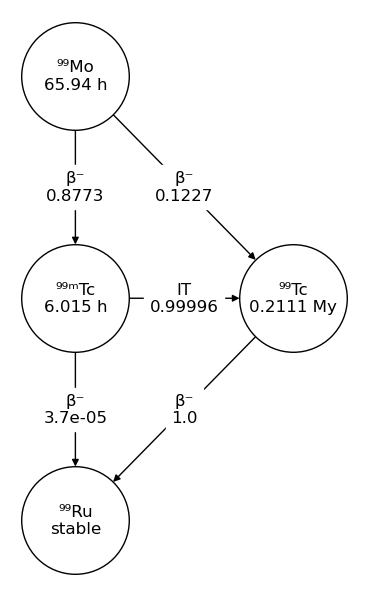

In [6]:
nuc = rd.Nuclide(radionuclide)
nuc.plot()

## Display the decay curve

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time (h)', ylabel='Activity (Bq)'>)

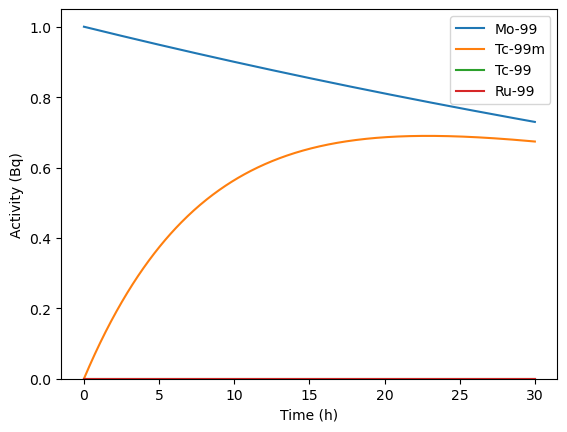

In [7]:
rad_t0 .plot(coolingTime, time_unit, yunits=activity_unit)

## Efficiency calculation as a function of the time

In [8]:
timeVec = np.arange(0,30,2) # time vector
effS, ueffS, effD, ueffD, effT, ueffT, effD2, ueffD2 = [], [], [], [], [], [], [],[]
for t in timeVec:
    rad_t1 = rad_t0.decay(t, time_unit)
    A_t1 = rad_t1.activities(activity_unit)
    As_t1 = sum(A_t1.values())
    
    rads = ""; pmf1 = ""
    for key, val in A_t1.items():
        if key != "Pb-208" and key != "Ru-99":
            rads += ', '+key
            pmf1 += ', '+str(val/As_t1)
    rads = rads[2:]
    pmf1 = pmf1[2:]
    
    out=td.TDCRPy.TDCRPy(L, rads, pmf1, N, kB, V, mode)
    effD.append(out[2]); ueffD.append(out[3]); effT.append(out[4]); ueffT.append(out[5])
    effS.append(out[0]); ueffS.append(out[1]); effD2.append(out[12]); ueffD2.append(out[13])

effD = np.asarray(effD); effT = np.asarray(effT); ueffD = np.asarray(ueffD); ueffT = np.asarray(ueffT);
effD2 = np.asarray(effD2); effS = np.asarray(effS); ueffD2 = np.asarray(ueffD2); ueffS = np.asarray(ueffS);
tdcr = effT/effD

warning p not equal to 1
warning p not equal to 1
warning p not equal to 1
warning p not equal to 1


## Plot efficiency curves

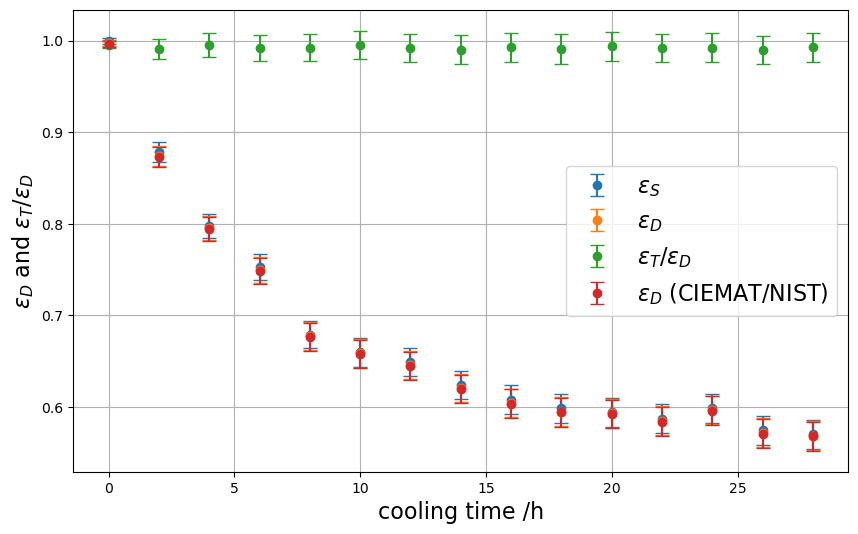

In [9]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(timeVec, effS, yerr=ueffS, fmt='o', capsize=5, label=r'$\epsilon_S$')
plt.errorbar(timeVec, effD, yerr=ueffD, fmt='o', capsize=5, label=r'$\epsilon_D$')
plt.errorbar(timeVec, tdcr, yerr=ueffT , fmt='o', capsize=5, label=r'$\epsilon_T/\epsilon_D$')
plt.errorbar(timeVec, effD2, yerr=ueffD2, fmt='o', capsize=5, label=r'$\epsilon_D$ (CIEMAT/NIST)')

# Adding titles and labels
#plt.title('Efficiency (effD) as a Function of Time')
plt.xlabel(f'cooling time /{time_unit}',fontsize=16)
plt.ylabel(r'$\epsilon_D$ and $\epsilon_T/\epsilon_D$',fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.savefig("plotDecay")
# Show the plot
plt.show()